# 零基础入门金融风控-贷款违约预测
- https://tianchi.aliyun.com/competition/entrance/531830/information

赛题以预测用户贷款是否违约为任务，数据集报名后可见并可下载，该数据来自某信贷平台的贷款记录，总数据量超过120w，包含47列变量信息，其中15列为匿名变量。为了保证比赛的公平性，将会从中抽取80万条作为训练集，20万条作为测试集A，20万条作为测试集B，同时会对employmentTitle、purpose、postCode和title等信息进行脱敏。

### 字段表

|     **Field**      |                       **Description**                        |
| :----------------: | :----------------------------------------------------------: |
|         id         |                为贷款清单分配的唯一信用证标识                |
|      loanAmnt      |                           贷款金额                           |
|        term        |                       贷款期限（year）                       |
|    interestRate    |                           贷款利率                           |
|    installment     |                         分期付款金额                         |
|       grade        |                           贷款等级                           |
|      subGrade      |                        贷款等级之子级                        |
|  employmentTitle   |                           就业职称                           |
|  employmentLength  |                        就业年限（年）                        |
|   homeOwnership    |              借款人在登记时提供的房屋所有权状况              |
|    annualIncome    |                            年收入                            |
| verificationStatus |                           验证状态                           |
|     issueDate      |                        贷款发放的月份                        |
|      purpose       |               借款人在贷款申请时的贷款用途类别               |
|      postCode      |         借款人在贷款申请中提供的邮政编码的前3位数字          |
|     regionCode     |                           地区编码                           |
|        dti         |                          债务收入比                          |
| delinquency_2years |       借款人过去2年信用档案中逾期30天以上的违约事件数        |
|    ficoRangeLow    |            借款人在贷款发放时的fico所属的下限范围            |
|   ficoRangeHigh    |            借款人在贷款发放时的fico所属的上限范围            |
|      openAcc       |              借款人信用档案中未结信用额度的数量              |
|       pubRec       |                      贬损公共记录的数量                      |
| pubRecBankruptcies |                      公开记录清除的数量                      |
|      revolBal      |                       信贷周转余额合计                       |
|     revolUtil      | 循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额 |
|      totalAcc      |              借款人信用档案中当前的信用额度总数              |
| initialListStatus  |                      贷款的初始列表状态                      |
|  applicationType   |       表明贷款是个人申请还是与两个共同借款人的联合申请       |
| earliesCreditLine  |              借款人最早报告的信用额度开立的月份              |
|       title        |                     借款人提供的贷款名称                     |
|     policyCode     |      公开可用的策略_代码=1新产品不公开可用的策略_代码=2      |
|   n系列匿名特征    |        匿名特征n0-n14，为一些贷款人行为计数特征的处理        |


### 评测标准
提交结果为每个测试样本是1的概率，也就是y为1的概率。评价方法为AUC评估模型效果（越大越好）。

In [1]:
import numpy as np 
import pandas as pd
import datetime
from matplotlib import pyplot as plt 
import seaborn as sns
import graphviz 
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

## 一、数据读取

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/testA.csv')
df_sub = pd.read_csv('./data/sample_submit.csv')

print("df_train shape: ", df_train.shape)
print("df_test shape: ", df_test.shape)
print("df_sub shape: ", df_sub.shape)

df_train shape:  (800000, 47)
df_test shape:  (200000, 46)
df_sub shape:  (200000, 2)


In [3]:
df_train.head(3)

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,Aug-2001,1.0,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,May-2002,1723.0,1.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,May-2006,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0


In [4]:
df_test.head(3)

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,800000,14000.0,3,10.99,458.28,B,B3,7027.0,10+ years,0,80000.0,0,2014-07-01,0,163.0,21,10.56,1.0,715.0,719.0,17.0,0.0,0.0,9846.0,30.7,29.0,0,0,Nov-1974,0.0,1.0,1.0,4.0,6.0,6.0,6.0,8.0,4.0,15.0,19.0,6.0,17.0,0.0,0.0,1.0,3.0
1,800001,20000.0,5,14.65,472.14,C,C5,60426.0,10+ years,0,50000.0,0,2015-07-01,2,235.0,8,21.40,2.0,670.0,674.0,5.0,0.0,0.0,8946.0,56.6,14.0,0,0,Jul-2001,5.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0,9.0,3.0,5.0,0.0,0.0,2.0,2.0
2,800002,12000.0,3,19.99,445.91,D,D4,23547.0,2 years,1,60000.0,2,2016-10-01,0,526.0,20,33.50,0.0,710.0,714.0,12.0,0.0,0.0,970.0,17.6,43.0,1,0,Aug-2006,0.0,1.0,0.0,1.0,4.0,4.0,1.0,1.0,36.0,5.0,6.0,4.0,12.0,0.0,0.0,0.0,7.0


In [5]:
[ i for i in df_train.columns.tolist() if i not in df_test.columns.tolist() ]

['isDefault']

In [6]:
# 合并训练集测试集
data = pd.concat([df_train, df_test], axis=0, ignore_index=True)

## 二、数据预处理
可以看到很多变量不能直接训练，比如grade、subGrade、employmentLength、issueDate、earliesCreditLine，需要进行预处理


In [7]:
print(sorted(data['grade'].unique()))
print(sorted(data['subGrade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


#### 首先对employmentLength进行转换到数值

In [8]:
data['employmentLength'].value_counts(dropna=False).sort_index()

1 year        65671
10+ years    328525
2 years       90565
3 years       80163
4 years       59818
5 years       62645
6 years       46582
7 years       44230
8 years       45168
9 years       37866
< 1 year      80226
NaN           58541
Name: employmentLength, dtype: int64

In [9]:
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)

def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)


In [10]:
data['employmentLength'].value_counts(dropna=False).sort_index()

0.0      80226
1.0      65671
2.0      90565
3.0      80163
4.0      59818
5.0      62645
6.0      46582
7.0      44230
8.0      45168
9.0      37866
10.0    328525
NaN      58541
Name: employmentLength, dtype: int64

#### 对earliesCreditLine进行预处理

In [11]:
data['earliesCreditLine'].sample(5)

636640    Nov-2005
671119    Aug-1986
751549    Jul-1989
114697    Oct-1994
998535    May-2002
Name: earliesCreditLine, dtype: object

In [12]:
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))


In [13]:
data['earliesCreditLine'].describe()


count    1000000.000000
mean        1998.688632
std            7.606231
min         1944.000000
25%         1995.000000
50%         2000.000000
75%         2004.000000
max         2015.000000
Name: earliesCreditLine, dtype: float64

### 缺失值处理

In [14]:
print('数据缺失比例')

df_tmp_null = ((data.isnull().sum())/data.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))
df_tmp_null = df_tmp_null.reset_index()
df_tmp_null = df_tmp_null[df_tmp_null[0] != '0.00%']
df_tmp_null

数据缺失比例


,index,0
0,isDefault,20.00%
1,n11,8.73%
2,employmentLength,5.85%
3,n8,5.04%
4,n14,5.04%
5,n6,5.04%
6,n1,5.04%
7,n2,5.04%
8,n3,5.04%
9,n5,5.04%


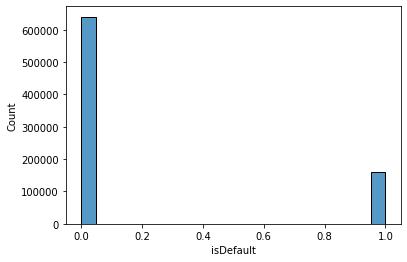

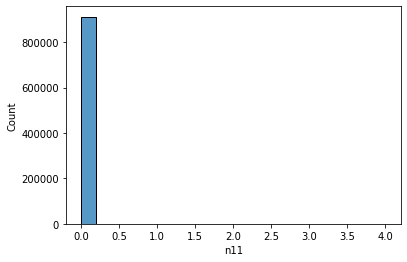

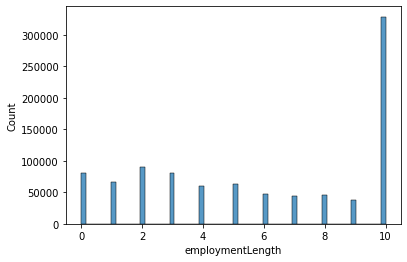

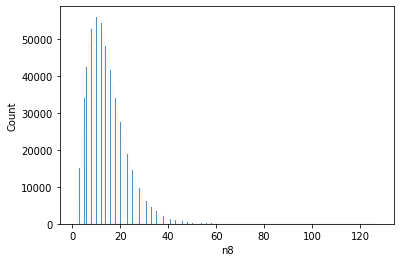

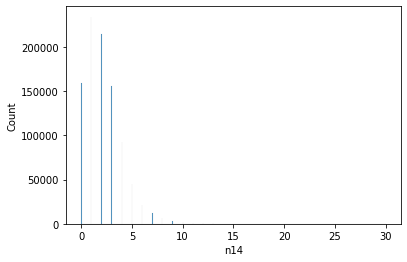

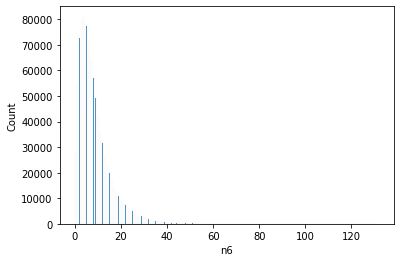

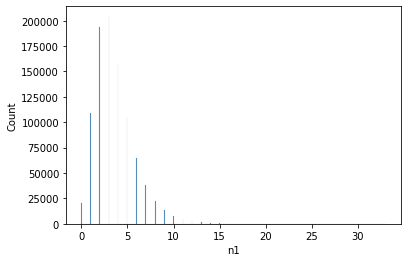

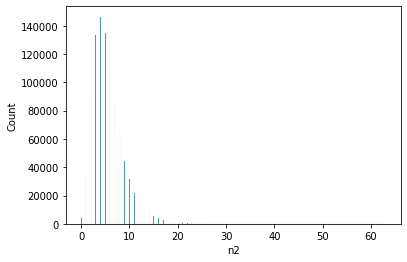

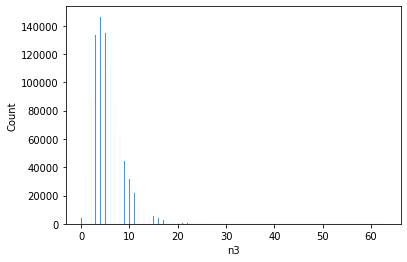

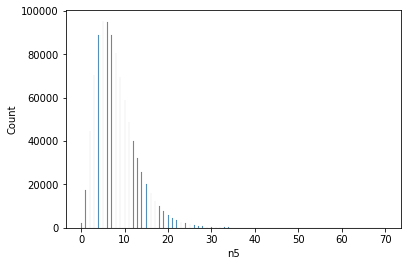

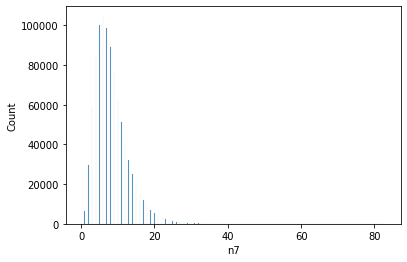

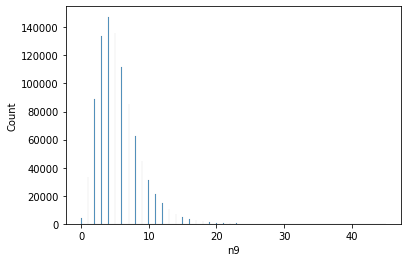

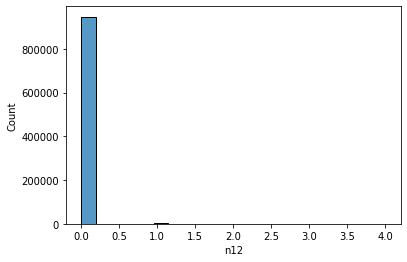

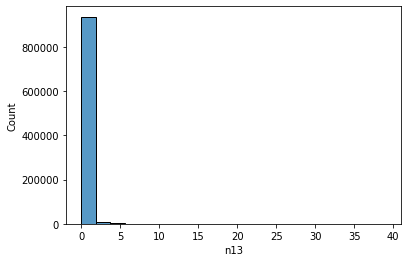

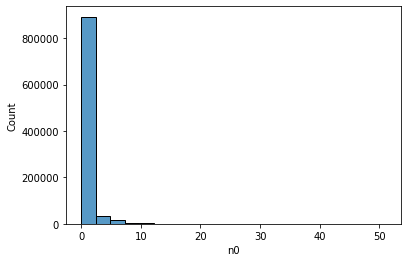

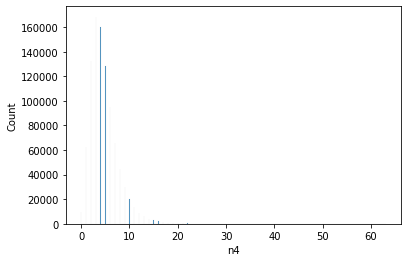

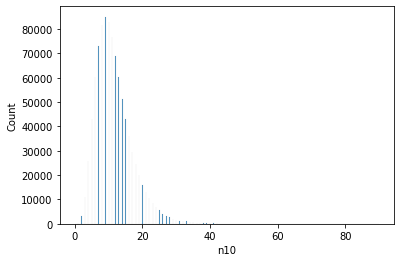

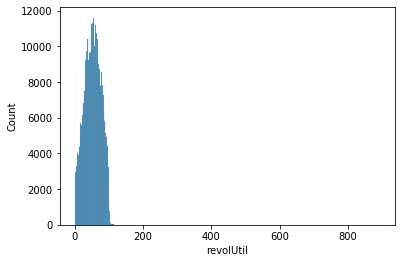

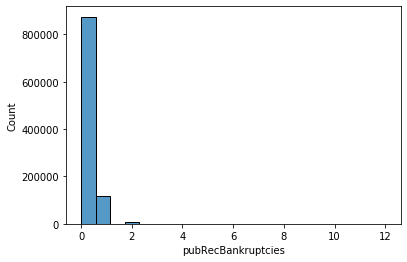

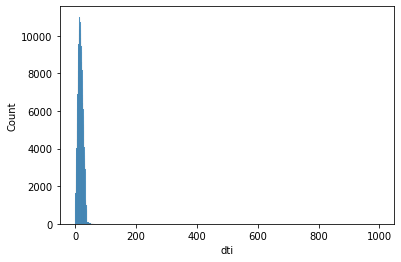

In [15]:
for col in df_tmp_null['index']:
    sns.histplot(data[col])
    plt.show()

In [16]:
data = data.fillna(-1)

In [17]:
print('数据缺失比例')
((data.isnull().sum())/data.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))


数据缺失比例


id                    0.00%
n3                    0.00%
totalAcc              0.00%
initialListStatus     0.00%
applicationType       0.00%
earliesCreditLine     0.00%
title                 0.00%
policyCode            0.00%
n0                    0.00%
n1                    0.00%
n2                    0.00%
n4                    0.00%
revolBal              0.00%
n5                    0.00%
n6                    0.00%
n7                    0.00%
n8                    0.00%
n9                    0.00%
n10                   0.00%
n11                   0.00%
n12                   0.00%
n13                   0.00%
revolUtil             0.00%
pubRecBankruptcies    0.00%
loanAmnt              0.00%
verificationStatus    0.00%
term                  0.00%
interestRate          0.00%
installment           0.00%
grade                 0.00%
subGrade              0.00%
employmentTitle       0.00%
employmentLength      0.00%
homeOwnership         0.00%
annualIncome          0.00%
issueDate           

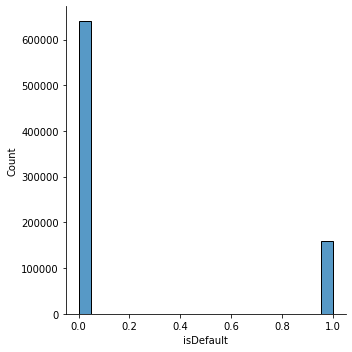

In [59]:
sns.displot(df_train['isDefault'])

## 三、特征工程

### 类别特征处理

In [18]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 298102
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 936
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 47904
policyCode 类型数： 1


In [19]:
# 类型数在2之上，又不是高维稀疏的，直接编码
data = pd.get_dummies(data, columns=['grade', 'subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)


In [20]:
# 高维类别特征需要进行转换
for f in ['employmentTitle', 'postCode', 'title']:
    data[f+'_cnts'] = data.groupby([f])['id'].transform('count')
    data[f+'_rank'] = data.groupby([f])['id'].rank(ascending=False).astype(int)
    del data[f]


## 四、模型训练

In [55]:
features = [f for f in data.columns if f not in ['id','issueDate','isDefault']]

train = data[:800000].reset_index(drop=True)
test = data[800000:].reset_index(drop=True)
print("train shape:", train.shape)
print("test shape:", test.shape)

x_train = train[features]
x_test = test[features]

y_train = train['isDefault']


train shape: (800000, 154)
test shape: (200000, 154)


### 决策树

In [35]:
model_dt = DecisionTreeClassifier()
model_dt = model_dt.fit(x_train, y_train)

In [36]:
r = export_text(model_dt, feature_names = features)
print(r)

|--- interestRate <= 13.18
|   |--- interestRate <= 9.73
|   |   |--- interestRate <= 7.88
|   |   |   |--- interestRate <= 6.67
|   |   |   |   |--- ficoRangeLow <= 732.50
|   |   |   |   |   |--- n11 <= -0.50
|   |   |   |   |   |   |--- regionCode_21 <= 0.50
|   |   |   |   |   |   |   |--- postCode_rank <= 23.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- postCode_rank >  23.50
|   |   |   |   |   |   |   |   |--- purpose_7 <= 0.50
|   |   |   |   |   |   |   |   |   |--- verificationStatus_1 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- delinquency_2years <= 5.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- delinquency_2years >  5.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- verificationStatus_1 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- n10 <= 15.50
|   |   |   |   |   |   |   |   |   |   |  

In [75]:
train_pre = model_dt.predict(x_train)
train_preproba = model_dt.predict_proba(x_train)
test_pre = model_dt.predict(x_test)
test_preproba = model_dt.predict_proba(x_test)

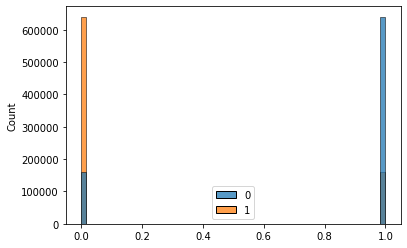

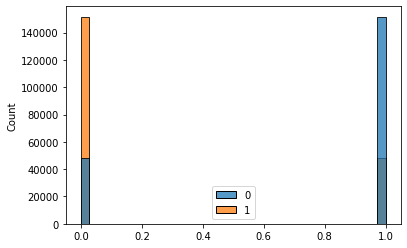

In [76]:
sns.histplot(train_preproba)
plt.show()
sns.histplot(test_preproba)
plt.show()


In [77]:
test_preproba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [81]:
df_sub['isDefault'] = test_preproba[:, 1]
df_sub.to_csv('./df_sub_dt.csv', index=False)
df_sub.head()

,id,isDefault
0,800000,0.0
1,800001,0.0
2,800002,0.0
3,800003,1.0
4,800004,0.0


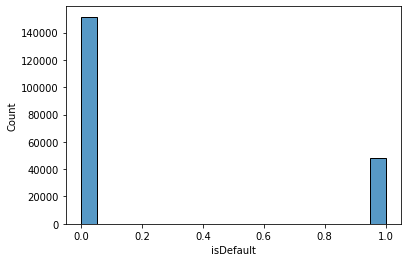

In [82]:
sns.histplot(df_sub['isDefault'])

### lgb

In [46]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [45]:
def get_lgb_binary():
    lgb_est = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=9,
        learning_rate=0.04,
        n_estimators=10000,
        objective='binary',
        subsample=0.9,
        subsample_freq=0,
        colsample_bytree=1.0,
        random_state=2019,
        n_jobs=-1,      
    )
    return lgb_est


In [47]:
train_X, val_X, train_y, val_y = train_test_split(x_train, y_train, test_size=0.3, random_state=2021)

lgb_est = get_lgb_binary()
lgb_est.fit(train_X, train_y, 
            eval_set=[(train_X,train_y),(val_X,val_y)],
            early_stopping_rounds=100,
            eval_metric=['auc'],
            verbose=20)


Training until validation scores don't improve for 100 rounds
[20]	training's auc: 0.708038	training's binary_logloss: 0.465939	valid_1's auc: 0.70614	valid_1's binary_logloss: 0.466523
[40]	training's auc: 0.713069	training's binary_logloss: 0.45622	valid_1's auc: 0.710522	valid_1's binary_logloss: 0.457244
[60]	training's auc: 0.71739	training's binary_logloss: 0.451978	valid_1's auc: 0.714164	valid_1's binary_logloss: 0.453437
[80]	training's auc: 0.721027	training's binary_logloss: 0.449464	valid_1's auc: 0.717173	valid_1's binary_logloss: 0.451289
[100]	training's auc: 0.724035	training's binary_logloss: 0.447632	valid_1's auc: 0.71957	valid_1's binary_logloss: 0.449803
[120]	training's auc: 0.726403	training's binary_logloss: 0.446249	valid_1's auc: 0.721347	valid_1's binary_logloss: 0.448759
[140]	training's auc: 0.728346	training's binary_logloss: 0.445151	valid_1's auc: 0.722649	valid_1's binary_logloss: 0.448008
[160]	training's auc: 0.730016	training's binary_logloss: 0.4442

LGBMClassifier(learning_rate=0.04, max_depth=9, n_estimators=10000,
               objective='binary', random_state=2019, subsample=0.9)

In [61]:
train_pre = lgb_est.predict(x_train)
train_preproba = lgb_est.predict_proba(x_train)
test_pre = lgb_est.predict(x_test)
test_preproba = lgb_est.predict_proba(x_test)

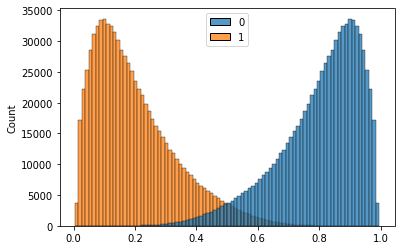

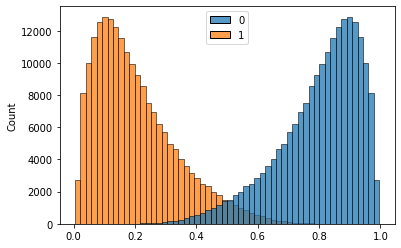

In [64]:
sns.histplot(train_preproba)
plt.show()
sns.histplot(test_preproba)
plt.show()


In [73]:
df_sub['isDefault'] = test_preproba[:, 1]
df_sub.to_csv('./df_sub_lgb.csv', index=False)
df_sub.head()

,id,isDefault
0,800000,0.087611
1,800001,0.398413
2,800002,0.601082
3,800003,0.304635
4,800004,0.291845


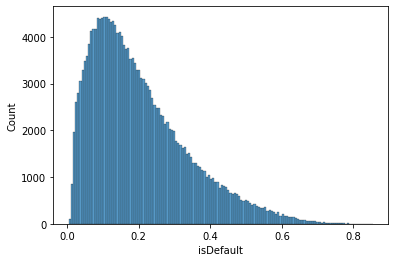

In [74]:
sns.histplot(df_sub['isDefault'])